# CNN Exercise 2: Image Classification with CNNs

We will use the CIFAR10 dataset, which consists of 60000 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. In this exercise we will only use the dog and cat classes and we will train a CNN to distinguish between the two.

In the following cell we load the dataset again from ```torchvision.datasets```. There is a bunch of code that is not relevant for this exercise, but you can have a look at it if you are interested. The important part is that we load training and test data, only select the dog and cat classes, and do some augmentation and normalizing of the data.

Thanks to [this Gist](https://gist.github.com/Miladiouss/6ba0876f0e2b65d0178be7274f61ad2f) for the code to load the CIFAR10 dataset.

Created by Cedric Ewen in 2023


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

from torchsummary import summary
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# transformations
RC = transforms.RandomCrop(32, padding=4)
RHF = transforms.RandomHorizontalFlip()
NRM = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
TT = transforms.ToTensor()

# transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TT, RC, RHF, NRM])
# transforms object for testset w/o augmentation
transform_no_aug = transforms.Compose([TT, NRM])

# downloading/louding CIFAR10 data
trainset = CIFAR10(
    root='data',
    train=True,
    download=True,
    transform=transform_with_aug)
testset = CIFAR10(
    root='data',
    train=False,
    download=True,
    transform=transform_no_aug)
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4,
             'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
           'horse', 'ship', 'truck']

# separating trainset/testset data/label
x_train = trainset.data
x_test = testset.data
y_train = np.array(trainset.targets)
y_test = np.array(testset.targets)

100%|██████████| 170M/170M [00:02<00:00, 72.2MB/s]


We now choose the classes we want to use for the classification. We start with cats and dogs and will later add more classes.

In [5]:
# This code block will remove all data samples that do not belong to
# class 'cat' or to class 'dog'.
classes = ['cat', 'dog']

# all classes of CIFAR-10
#classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# initialize masks and map according to chosen classes
mask_train = np.zeros(len(y_train), dtype=bool)
mask_test = np.zeros(len(y_test), dtype=bool)
lable_map = {}
for i, class_name in enumerate(classes):
    mask_train = mask_train | (y_train == classDict[class_name])
    mask_test = mask_test | (y_test == classDict[class_name])
    lable_map[classDict[class_name]] = i

# select data
trainset.data = x_train[mask_train]
testset.data = x_test[mask_test]
trainset.targets = y_train[mask_train].tolist()
testset.targets = y_test[mask_test].tolist()

# make class labels continuous again
trainset.targets = [lable_map[e] for e in trainset.targets]
testset.targets = [lable_map[e] for e in testset.targets]

In [6]:
batch_size = 64

# create dataset loaders from trainset and testset
kwargs = {'num_workers': 4, 'pin_memory': False,
          'batch_size': batch_size}
trainloader = DataLoader(
    trainset, shuffle=True, **kwargs)
testloader = DataLoader(
    testset, shuffle=False, **kwargs)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


We now have a training and test set of the selected classes that are one-hot-encoded. Let's look at some of the images.
- What's the size of the images?
- How many images do we have in training and test set?

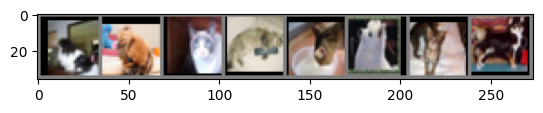

dog   dog   cat   cat   cat   dog   cat   dog  


In [7]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)

images, labels = next(dataiter)

images_to_plot = 8

# show images
imshow(torchvision.utils.make_grid(images[:images_to_plot]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(images_to_plot)))

In [9]:
# TODO: print image shape and dataset length
print(images.shape)
print(len(trainset))

torch.Size([64, 3, 32, 32])
10000


# Define the Network
This is the only area you will need to change.  Look at the picture of LeNet here.

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #TODO: define the layers


        self.conv1 = nn.Conv2d(in_channels=  3, out_channels=6*3, kernel_size=5, stride=1, padding=2) # 32x32 -> 32x32
        self.conv2 = nn.Conv2d(in_channels=6*3, out_channels=16*3,  kernel_size=5, stride=1, padding=0) # 16x16 -> 12x12

        self.pooling1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)                              # 32x32 -> 16x16
        self.pooling2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)                              # 12x12 ->  6x 6

        self.fully_connected1 = nn.Linear(in_features=6*6*16*3, out_features=120)
        self.fully_connected2 = nn.Linear(in_features=120, out_features=84)
        self.fully_connected3 = nn.Linear(in_features=84,out_features=2)

        # Alex start
        #self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0)
        #self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2)



        # You can implement the network from exercise 1.
        # Try not to do copy-and-paste.
        # You will have to change some numbers because the image size is different and we now have RGB instead of greyscale.
        # We also use only 2 classes (cats and dogs) now instead of 10.




    def forward(self, x):
        #TODO: run layer
        x = self.conv1(x)
        x = F.sigmoid(x)
        x = self.pooling1(x)

        x = self.conv2(x)
        x = F.sigmoid(x)
        x = self.pooling2(x)

        x = torch.flatten(x, 1)
        x = self.fully_connected1(x)

        x = torch.sigmoid(x)
        x = self.fully_connected2(x)
        x = torch.sigmoid(x)

        x = self.fully_connected3(x)

        output = x
        return output

In [21]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 18, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(18, 48, kernel_size=(5, 5), stride=(1, 1))
  (pooling1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (pooling2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fully_connected1): Linear(in_features=1728, out_features=120, bias=True)
  (fully_connected2): Linear(in_features=120, out_features=84, bias=True)
  (fully_connected3): Linear(in_features=84, out_features=2, bias=True)
)


In [22]:
summary(model, (3, 32, 32), batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [64, 18, 32, 32]           1,368
         AvgPool2d-2           [64, 18, 16, 16]               0
            Conv2d-3           [64, 48, 12, 12]          21,648
         AvgPool2d-4             [64, 48, 6, 6]               0
            Linear-5                  [64, 120]         207,480
            Linear-6                   [64, 84]          10,164
            Linear-7                    [64, 2]             170
Total params: 240,830
Trainable params: 240,830
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 15.57
Params size (MB): 0.92
Estimated Total Size (MB): 17.24
----------------------------------------------------------------


# Training

In [23]:
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

In [24]:
# move model to GPU
model = model.to(device)

In [25]:
learning_rate = 0.01
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

The training loop is the same as in the previous exercise. The only difference is that we have added a validation loop, where we evaluate the model on the validation set (in our case the test data). We additionally save the loss and accuracy for both the training and validation set in a list, so that we can plot them later. The accuracy is the fraction of correctly classified images.

In [28]:
from tqdm import tqdm
def train(num_epochs, model, trainloader, testloader):

    train_losses = []
    train_accuracy = []

    val_losses = []
    val_accuracy = []

    # Train the model
    for epoch in tqdm(range(num_epochs)):
    #for epoch in range(num_epochs):

        # training
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        # In this loop 2 important lines are missing
        # Do you notice what's missing?
        # Hint: Compare to train() in exercise 1
        for i, (images, labels) in enumerate(trainloader, 0):

            # move data to GPU
            images = images.to(device)
            labels = labels.to(device)

            # run model
            output = model(images)


            # clear gradients for this training step
            optimizer.zero_grad()

            loss = loss_func(output, labels)
            # backpropagation, compute gradients
            loss.backward()
            optimizer.step()

            # save metrics for ploting
            train_loss += loss.item()
            train_acc += (output.argmax(dim=1) == labels).float().mean().item()

        train_loss = train_loss / len(trainloader)
        train_acc = train_acc / len(trainloader)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)

        # validation
        model.eval()
        with torch.no_grad():  #switch off autograd
            val_loss = 0.0
            val_acc = 0.0
            for i, (images, labels) in enumerate(testloader, 0):
                images = images.to(device)
                labels = labels.to(device)
                pred = model(images)
                v_loss = loss_func(pred, labels)
                val_loss += v_loss.item()
                val_acc += (pred.argmax(dim=1) == labels).float().mean().item()

            val_loss = val_loss / len(testloader)
            val_acc = val_acc / len(testloader)
            val_losses.append(val_loss)
            val_accuracy.append(val_acc)

        print(f"Epoch: {epoch+1}/{num_epochs} | loss: {train_loss} - acc: {train_acc} | val_loss: {val_loss} - val_acc: {val_acc}")

    print(f"Finished training after {num_epochs} epochs")
    print(f"Best validation accuracy: {max(val_accuracy)}")
    return train_losses, val_losses, train_accuracy, val_accuracy

num_epochs = 60
train_losses, val_losses, train_accuracy, val_accuracy = train(num_epochs, model, trainloader, testloader)

  0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  2%|▏         | 1/60 [00:22<22:03, 22.43s/it]

Epoch: 1/60 | loss: 0.7394577173670386 - acc: 0.5008957006369427 | val_loss: 0.7381984647363424 - val_acc: 0.5029296875


  3%|▎         | 2/60 [00:38<18:02, 18.66s/it]

Epoch: 2/60 | loss: 0.7403786717706425 - acc: 0.4994028662420382 | val_loss: 0.7381984647363424 - val_acc: 0.5029296875


  3%|▎         | 2/60 [00:43<20:53, 21.62s/it]


KeyboardInterrupt: 

# Evaluation

In [ ]:
plt.plot(np.array(train_losses), label='Training loss')
plt.plot(np.array(val_losses), label='Validation loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.array(train_accuracy), label='Training Accuracy')
plt.plot(np.array(val_accuracy), label='Validation Accuracy')
plt.legend()
plt.show()

In the following, we will evaluate the last epoch on the test dataset and calculate the accuracy, look at some outputs and the confusion matrix.

In [ ]:
# predicting labels for test data and calculating accuracy
correct = 0
total = 0
test_preds = []
test_labels = []
test_images = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        test_preds.append(predicted.cpu())
        test_labels.append(labels.cpu())
        test_images.append(images.cpu())
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
    test_preds = torch.cat(test_preds).numpy()
    test_labels = torch.cat(test_labels).numpy()
    test_images = torch.cat(test_images)

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

In [ ]:
images_to_plot = 8

# show images
imshow(torchvision.utils.make_grid(test_images[:images_to_plot]))
# print labels
print('Truth:     ', ' '.join(f'{classes[test_labels[j]]:5s}' for j in range(images_to_plot)))
print('Predicted: ', ' '.join(f'{classes[test_preds[j]]:5s}' for j in range(images_to_plot)))

In [ ]:
# Create confusion matrix and normalizes it over true labels
confusion = confusion_matrix(test_labels, test_preds, normalize='true')

# Create a plot of the confusion matrix
fig, ax = plt.subplots(figsize=(15, 7))
ConfusionMatrixDisplay(confusion, display_labels=classes).plot(ax=ax)
plt.show()

# Task

**Create a CNN that achieves a validation accuracy of at least 70%**

- Feel free to experiment on the network structure yourself. Use a combination of convolutional and pooling layers, similar to the first exercise.
- If your train and validation metrics diverge, you should consider including [Dropout layers](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

# Bonus tasks

- A network with many parameters may perform better but a small network is trained faster and requires less computing resources. Can you reach the 70% validation accuracy in less than 20 epochs?
- The dataset does not only contain Cat and Dog pictures but 10 classes in total. You could rebuild the model as a multi-classifier. To achieve this, you would need to:
    - Include additional classes in your input. Do this by commenting out the one line of code in the data loading section.
    - What else do you need to change to make the model a multi-classifier?
    - Try to achieve the best validation accuracy you can. Which other parameters besides the architecture can you change to affect the performance?
- Implement a ResNet and apply it to the dataset. For example, you can add another class inheriting from `nn.Module` that implements a single reset block, including two convolutions, activation function and the skip connection.